# Reinforcement Learning

by Jonas Peters and Rune Christiansen, 21.06.2019

This notebook aims to give you a basic understanding of reinforcement learning. It is based on a practical application to the game tictactoe. 

In [12]:
library(hash)

hash-2.2.6 provided by Decision Patterns



Reinforcement learning can be understood by imagining an agent that takes actions according to a given (probabilistic) strategy. The agent is embedded in a world that determines what resembles a permitted move. After taking a set of actions, the agent receives a reward. Based on the profitability of his actions, he then repeatedly updates his strategy, striving towards maximizing this reward. We now make this intuition notion more precise.

For every $t = 1,2, \dots, T$, let $S_t$ and $A_t$ denote the ''state of the world'' at time $t$ and the action that is taken at time $t$, respectively. We let $Y$ denote a reward. The variables $Y, S_1, A_1, \dots, S_T, A_T$ are part of a causal system in which, for all $t$, $\mathbf{PA}(A_t) = S_t$, i.e., the action at time $t$ is taken only on the basis of the current state of the world. The way in which this action is chosen is called a _strategy_. More formally, a strategy $\pi$ is a mapping $(a,s) \mapsto \pi(a \, \vert \, s) := \mathbb{P}(A_t = a \, \vert \, S_t = s)$. 

How should an agent update his strategy? A natural choice is to pick the one that yields the highest expected reward. In practice, the expected rewards under different strategies are unkown and need to be estimated from data. This involves estimating properties of a distribution (the reward distribution under a given strategy) that we do not observe data from (the strategy has not yet been used). Exploiting knowledge of the underlying causal structure, this can be done be inverse probability weighting.

## Inverse Probability Weighting

Let $\mathbf{X} = (Y, S_1, A_1, \dots, S_T, A_T)$ denote the full system of variables. Let $\pi$ and $\tilde{\pi}$ be two different strategies, and let $p$ and $\tilde{p}$ denote the respective densities over $\mathbf{X}$ that are induced by these strategies. Using Markov factorization of $p$ and $\tilde{p}$ we see that
\begin{equation}
\xi := \tilde{\mathbb{E}} [Y] = 
\int y \, \tilde{p}(\mathbf{x}) \,  d \mathbf{x} = 
\int y \, \frac{\tilde{p}(\mathbf{x})}{p(\mathbf{x})} p(\mathbf{x}) \,  d \mathbf{x} = 
\int y \, \frac{\prod_{t=1}^T \tilde{p}(a_t \, \vert \, s_t)}{\prod_{t=1}^T p(a_t \, \vert \, s_t)} \, p(\mathbf{x}) \, d \mathbf{x} = 
\int y \, \frac{\prod_{t=1}^T \tilde{\pi}(a_t \, \vert \, s_t)}{\prod_{t=1}^T \pi(a_t \, \vert \, s_t)} \, p(\mathbf{x}) \, d \mathbf{x} = 
\mathbb{E} \left[ Y \ \frac{\prod_{t=1}^T \tilde{\pi}(A_t \, \vert \, S_t)}{\prod_{t=1}^T \pi(A_t \, \vert \, S_t)} \right],
\end{equation}

i.e., the expected return $\xi$ under strategy $\tilde{\pi}$ can be optained from the distribution $p$ induced by the original strategy $\pi$. In practice, this means that we can estimate $\xi$ given data $\mathbf{X}^1, \dots, \mathbf{X}^n$ obtained under strategy $\pi$:

\begin{equation} \tag{1}
\hat \xi_n := \frac{1}{n} \sum_{i=1}^n Y^i \frac{\prod_{t=1}^T \tilde{\pi}(A_t^i \, \vert \, S_t^i)}{\prod_{t=1}^T \pi(A_t^i \, \vert \, S_t^i)}.
\end{equation}

## TicTacToe

Imagine you are playing a game of TicTacToe against another player. At every stage of the game, the current "state of the world" can be described by a 9-dimensional vector $s \in \mathcal{S} := \{-1,0,1\}^9$ indicating which fields are marked by an "o" (-1), which are marked by an "x" (1) and which are left blank (0). (In practice, many of the elements in $\mathcal{S}$ do not correspond to possible game states, but this is irrelevant for the application.) An action corresponds to choosing one of the free fields, i.e., the possible actions are $\mathcal{A} := \{1, \dots, 9\}$. The reward $Y \in \{-1,0,1\}$ (defeat/draw/win) is obtained after a game is finished.

Below, we give an implementation of the game. 

In [4]:
## The Game

game <- function(player1, player2, silent = FALSE){
  gameState <- rep(0,9)
  
  while(evaluateGameState(gameState)==42){
    movePlus1 <- do.call(player1, list(gameState))$move
    gameState[movePlus1] <- 1
    if(evaluateGameState(gameState)==42){
      moveMinus1 <- do.call(player2, list(-gameState))$move
      gameState[moveMinus1] <- -1
    }
  }
  evGS <- evaluateGameState(gameState)
  if(evGS==0){
    do.call(paste(player1, ".draw", sep = ""), list())
    do.call(paste(player2, ".draw", sep = ""), list())
    totalResults[totalGames] <<- 0 
    res <- 0 
    if(!silent){
      cat("Draw!")
      cat("\n\n")
      cat("Result:")
      cat("\n\n")
      print(matrix(gameState,3,3,byrow=T))
    }
  }
  if(evGS==1){
    res <- 1 
    do.call(paste(player1, ".win", sep = ""), list())
    do.call(paste(player2, ".loss", sep = ""), list())
    totalResults[totalGames] <<- 1 
    if(!silent){
      print("The winner is player 1")
      cat("\n\n")
      cat("Result:")
      cat("\n\n")
      print(matrix(gameState,3,3,byrow=T))
    }
  }
  if(evGS==-1){
    res <- -1 
    totalResults[totalGames] <<- -1 
    do.call(paste(player1, ".loss", sep = ""), list())
    do.call(paste(player2, ".win", sep = ""), list())
    if(!silent){
      print("The winner is player -1")
      cat("\n\n")
      cat("Result:")
      cat("\n\n")
      print(matrix(gameState,3,3,byrow=T))
    }
  }
  return(res)
}

## gamestate

evaluateGameState <- function(gameState, permut = (1:9)){
  gameState <- gameState[permut]
  gameStateMat <- matrix(gameState, 3, 3, byrow = T)
  rSums <- rowSums(gameStateMat)
  cSums <- colSums(gameStateMat)
  dSums <- c(sum(gameState[c(1,5,9)]), sum(gameState[c(3,5,7)]))
  sums  <- c(rSums, cSums, dSums)
  if(any(sums==3)) return(1)
  else if(any(sums==-3)) return(-1)
  else if(any(gameState==0)) return(42)
  else return(0)
}



## players
    
######################## playerRandom ########################
# chooses randomly among empty fields
playerRandom <- function(gameState){
  move <- sample((1:9)[which(gameState==0)],1) 
  return(list(move = move)) 
}
    
playerRandom.draw <- function(){
  historyRandom$n <<- historyRandom$n + 1 
  historyRandom$results[historyRandom$n] <<- 0 
}
playerRandom.win <- function(){
  historyRandom$n <<- historyRandom$n + 1 
  historyRandom$results[historyRandom$n] <<- 1 
}
playerRandom.loss <- function(){
  historyRandom$n <<- historyRandom$n + 1 
  historyRandom$results[historyRandom$n] <<- -1 
}


######################## playerLeft ########################
# chooses the leftmost empty field
playerLeft <- function(gameState){ 
  move <- which.min(abs(gameState)) 
  return(list(move = move)) 
}

playerLeft.draw <- function(){
  historyLeft$n <<- historyLeft$n + 1 
  historyLeft$results[historyLeft$n] <<- 0 
}
playerLeft.win <- function(){
  historyLeft$n <<- historyLeft$n + 1 
  historyLeft$results[historyLeft$n] <<- 1 
}
playerLeft.loss <- function(){
  historyLeft$n <<- historyLeft$n + 1 
  historyLeft$results[historyLeft$n] <<- -1 
}


### Exercise 1
Get familiar with the code. Play a couple of games between playerLeft and playerRandom. Which strategy seems to work best?

### Solution 1

In [5]:
historyRandom <- list(n = 0, results = NA, games = list())
historyLeft <- list(n = 0, results = NA, games = list())
totalGames <- 0
totalResults <- c()

#########################
## Play PlayerLeft against PlayerRandom
## fill in 
#########################

### End of Solution 1

## Estimating expected rewards

A strategy for playing TicTacToe is a map 
$$
\pi : \mathcal{A} \times \mathcal{S} \to [0,1], \qquad \text{ such that for all } s \in \mathcal{S}, \sum_{a \in \mathcal{A}}\pi(a \, \vert \, s) = 1.
$$

We can parametrize the space of strategies by $\theta \in \mathbb{R}^{\vert\mathcal{A}\vert \times \vert \mathcal{S} \vert}$ using
\begin{equation} \tag{2}
\pi_{\theta}(a \, \vert \, s) = \mathbb{P}_\theta(A_t = a \, \vert \, S_t = s) = \frac{\exp(\theta_{as})}{\sum_{\theta_{a^\prime \in \mathcal{A}}} \exp{(\theta_{a^\prime s})}}.
\end{equation}

Assume that we play a numer of games $i=1,\dots,n$ under a given strategy, and assume that we have saved this strategy, i.e., the probabilities $\pi_{\text{data}}(A_j^i \, \vert \, S_j^i)$ are known (and fixed). Using (1), we can estimate the performance under a new strategy $\theta$ by
\begin{equation} \tag{3}
\hat \xi_{n}(\theta) = 
\frac{1}{n} \sum_{i=1}^n Y_i \frac{p_\theta(\text{game}_{i})}{p_\text{data}(\text{game}_{i})} = 
\frac{1}{n} \sum_{i=1}^n Y_i \,
 \frac{\pi_{\theta}(A_1^i \, \vert \, S_1^i) \pi_{\theta}(A_2^i \, \vert \, S_2^i) \pi_{\theta}(A_3^i \, \vert \, S_3^i) \pi_{\theta}(A_4^i \, \vert \, S_4^i)}
{\pi_{\text{data}}(A_1^i \, \vert \, S_1^i) \pi_{\text{data}}(A_2^i \, \vert \, S_2^i) \pi_{\text{data}}(A_3^i \, \vert \, S_3^i) \pi_{\text{data}}(A_4^i \, \vert \, S_4^i)},
\end{equation}

### Exercise 2 
We now play 10,000 games against <tt>PlayerLeft</tt> using the random strategy.
Use the estimator (2) to estimate the 
performance against <tt>PlayerLeft</tt> if you play the same strategy as <tt>PlayerLeft</tt>.
What is the true expected score in that case?

We first update <tt>PlayerRandom</tt> to save information about the played moves and the probability with which they were taken. 

### Solution 2

In [6]:
# updated playerRandom
playerRandom <- function(gameState){ 
  probmass <- rep(0,9) 
  probmass[gameState == 0] <- 1/sum(gameState == 0) 
  move <- sample(1:9, size=1, prob = probmass) 
  ngames <- historyRandom$n + 1 
  if(sum(gameState==0)>7){  
    # There is at most 1 occupied field. It is thus playerRandom's first turn.
    # We initialize entry number 'ngames' in historyRandom$games.
    # historyRandom$games contains information on the current gamestate, 
    # the move taken, and the probability with which it was taken.
    historyRandom$games[[ngames]] <<- c(gameState, move, probmass[move]) 
  }else{ 
    # We update entry number 'ngames' in historyRandom
    historyRandom$games[[ngames]] <<- rbind(historyRandom$games[[ngames]], c(gameState, move, probmass[move]))
  }
  return(list(move = move))
}

[1] 0.0763

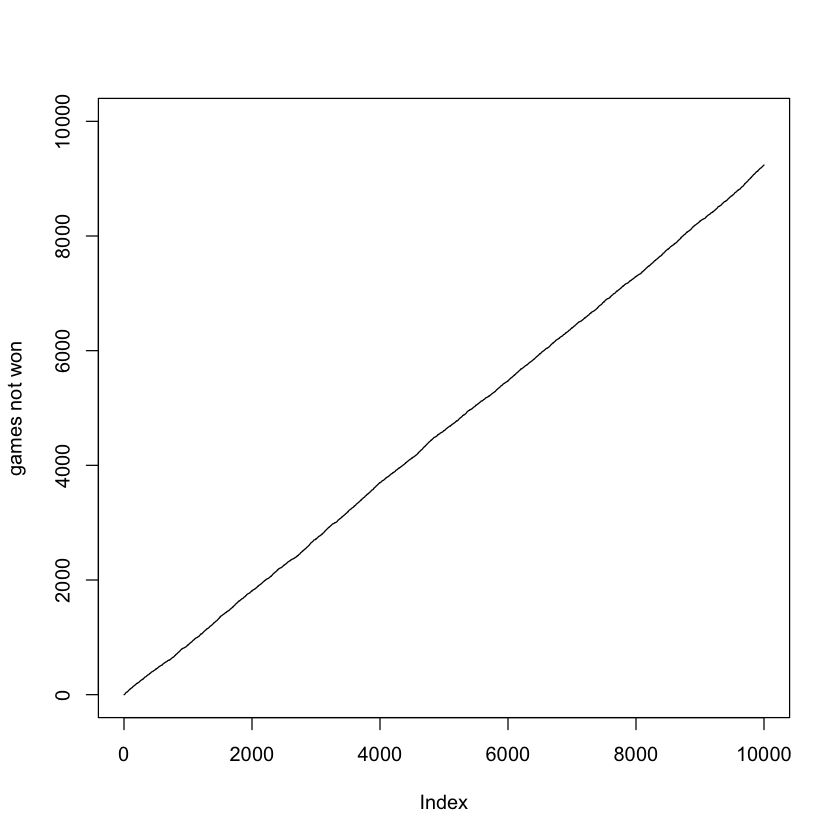

In [7]:
# 10000 games between PlayerRandom and PlayerLeft
historyRandom <- list(n = 0, results = NA, games = list())
set.seed(1)
numGames <- 10000
player1 <- "playerRandom" 
player2 <- "playerLeft" 

totalResults <- c()
totalGames <- 1

for(i in 1:numGames){
  game(player1, player2, silent = TRUE)  
  totalGames <- totalGames +1
}

# play 10000 games
plot((1:numGames) - cumsum(totalResults), xlim = c(0,numGames), 
     ylim = c(0,numGames), ylab = "games not won", type = "l")

# average reward
mean(historyRandom$results)

In [8]:
#### compute expected reward under strategy of playerLeft 

weights <- rep(1,historyRandom$n) # initializing weights
for(i in 1:historyRandom$n){
  currentgame <- historyRandom$games[[i]]
  # update weights, i.e., compute the fraction in the i'th term of the sum in (3)
  for(j in 1:(dim(currentgame)[1])){ 
    #########################
    ## fill in
    ######################### 
  }
}

# estimate for expected reward under the strategy of playerLeft
mean(weights*historyRandom$results)

[1] 0.0763

### End of Solution 2

### Updating the strategy using gradient descent

In order to sequentially move towards a higher reward, we can, at every step, update our strategy by moving in a ascent direction of (3). We first need to calculate an expression for the gradient of (3). 

#### Computing the gradient

Given $a$ and $s$.
Let us separate the games $\{1, \ldots, n\}$ into three distinct subsets $\mathcal{S}$, $\mathcal{T}$, and $\mathcal{U}$, s.t. 
$\{1, \ldots, n\} = 
\mathcal{S} \cup \mathcal{T} \cup \mathcal{U}$. 
$\mathcal{S}$ contains all $i$, s.t. there is a $j \in \{1, 2, 3, 4\}$ with 
$S_j^i = s$ and $A_j^i = a$.
$\mathcal{T}$ contains all $i$, s.t. there is a $j \in \{1, 2, 3, 4\}$ with 
$S_j^i = s$ but $A_j^i \neq a$.
$\mathcal{U}$ is the rest.
We have
$$
\frac{\partial}{\partial \theta_{as}}
\frac{\exp(\theta_{as})}{\sum_{a'} \exp(\theta_{a's})}
= 
\left(1 - \frac{\exp(\theta_{as})}{\sum_{a'} \exp(\theta_{a's})}\right)
\frac{\exp(\theta_{as})}{\sum_{a'} \exp(\theta_{a's})}.
$$
and
$$
\frac{\partial}{\partial \theta_{as}}
\frac{\exp(\theta_{\tilde{a}s})}{\sum_{a'} \exp(\theta_{a's})}
= 
- 
\frac{\exp(\theta_{as})}{\sum_{a'} \exp(\theta_{a's})}
\frac{\exp(\theta_{\tilde{a}s})}{\sum_{a'} \exp(\theta_{a's})}.
$$
Thus,
\begin{align*}
\frac{\partial}{\partial \theta_{as}}\hat E (\theta)
&= 
\frac{1}{n}\left(
\sum_{i \in \mathcal{S}} 
Y_i
\left(1 - \frac{\exp(\theta_{as})}{\sum_{a'} \exp(\theta_{a's})}\right)
\frac{\pi_{\theta}(A_1^i \, \vert \, S_1^i) \pi_{\theta}(A_2^i \, \vert \, S_2^i) \pi_{\theta}(A_3^i \, \vert \, S_3^i) \pi_{\theta}(A_4^i \, \vert \, S_4^i)}
{\pi_{\text{data}}(A_1^i \, \vert \, S_1^i) \pi_{\text{data}}(A_2^i \, \vert \, S_2^i) \pi_{\text{data}}(A_3^i \, \vert \, S_3^i) \pi_{\text{data}}(A_4^i \, \vert \, S_4^i)}\right.\\
&\qquad 
\left.+
\sum_{i \in \mathcal{T}} 
Y_i
\left(- \frac{\exp(\theta_{as})}{\sum_{a'} \exp(\theta_{a's})}\right)
\frac{\pi_{\theta}(A_1^i \, \vert \, S_1^i) \pi_{\theta}(A_2^i \, \vert \, S_2^i) \pi_{\theta}(A_3^i \, \vert \, S_3^i) \pi_{\theta}(A_4^i \, \vert \, S_4^i)}
{\pi_{\text{data}}(A_1^i \, \vert \, S_1^i) \pi_{\text{data}}(A_2^i \, \vert \, S_2^i) \pi_{\text{data}}(A_3^i \, \vert \, S_3^i) \pi_{\text{data}}(A_4^i \, \vert \, S_4^i)}
\right).
\\
\end{align*}

#### Performing the gradient step

Let $\lambda>0$. Given a current strategy $\theta^{current}$, we perform a gradient step by updating, for all $a,s$,
$$
\theta_{as} \leftarrow \theta_{as} + \lambda \frac{\partial}{\partial \theta_{as}}\hat E (\theta) |_{\theta = \theta^{current}}
$$

### Exercise 3

Fill in the relevant lines of code in the below implementation of the gradient step. We first define the new player, <tt>PlayerLearn</tt>.

In [9]:
######################## playerLearn ########################
## updates strategy based on experience
playerLearn <- function(gameState){ 
  if(is.null(strategyLearn[[toString(gameState)]])){ 
    # if gamestate has not been seen yet,
    # initialize strategy by uniform
    probmass <- rep(0,9) 
    probmass[gameState == 0] <- 1/sum(gameState == 0) 
    strategyLearn[[toString(gameState)]] <<- log(probmass) 
  } else { 
    # otherwise use current paramters in strategyLearn
    # and compute strategy from Equation (2)
    probmass <- exp(strategyLearn[[toString(gameState)]])/sum(exp(strategyLearn[[toString(gameState)]])) 
  }
  move <- sample(1:9, size=1, prob = probmass) 
  ngames <- historyLearn$n + 1 
  if(sum(gameState==0)>7){  
    historyLearn$games[[ngames]] <<- c(gameState, move, probmass[move]) 
  }else{ 
    historyLearn$games[[ngames]] <<- rbind(historyLearn$games[[ngames]], c(gameState, move, probmass[move]))
  }
  return(list(move = move))
}

playerLearn.draw <- function(){
  historyLearn$n <<- historyLearn$n + 1
  historyLearn$results[historyLearn$n] <<- 0
  playerLearn.update()
}
playerLearn.win <- function(){
  historyLearn$n <<- historyLearn$n + 1
  historyLearn$results[historyLearn$n] <<- 1
  playerLearn.update()
}
playerLearn.loss <- function(){
  historyLearn$n <<- historyLearn$n + 1
  historyLearn$results[historyLearn$n] <<- -1
  playerLearn.update()
}

In [10]:
playerLearn.update <- function(){
  stepsize <- lambda/historyLearn$n # decrease stepsize with time
  
  # compute gradient
  if((totalGames >  waitUntilStep) && ((totalGames %% doStepEvery) == doStepEvery-1)){ # update strategy
    gradientLearn <- copy(strategyLearn)
    .set(gradientLearn, keys(gradientLearn), rep(list(rep(0,9)),length(keys(gradientLearn))))
    for(i in 1:historyLearn$n){
      gamee <- historyLearn$games[[i]]
      gamee
      wup <- 1
      wdown <- 1
      
      for(j in 1:dim(gamee)[1]){
        gs <- gamee[j,1:9]
        
        # wup looks at current probabilities. 
        ac = gamee[j,10]
        wup <- wup * exp(strategyLearn[[toString(gs)]][ac])/sum(exp(strategyLearn[[toString(gs)]]))
        # wdown looks at probabilities, under which the action was decided. 
        wdown <- wdown * gamee[j,11]
      }
      if(wup > 0){ #if games have zero prob. they are disregarded.
        for(j in 1:dim(gamee)[1]){
          # get hashed game state
          gs <- gamee[j,1:9]
          ac <- gamee[j,10]
          gradientLearn[[toString(gs)]][ac] = gradientLearn[[toString(gs)]][ac] + 
            historyLearn$results[i] * wup/wdown * (1 - exp(strategyLearn[[toString(gs)]][ac])/sum(exp(strategyLearn[[toString(gs)]])))
          others <- setdiff(which(strategyLearn[[toString(gs)]] > -Inf), ac)
          gradientLearn[[toString(gs)]][others] = gradientLearn[[toString(gs)]][others] - 
            historyLearn$results[i] * wup/wdown * exp(strategyLearn[[toString(gs)]][others])/sum(exp(strategyLearn[[toString(gs)]]))
        }
      }
    }
      
    # gradient step 
    for(i in keys(strategyLearn)){
      # compute update of i'th entry in strategyLearn
      # store result in object 'newVector'
      
      ######################################
      ## change the following assignment
      newVector <- rep(1,9)
      ######################################
        
      newVector <- newVector - mean(newVector[newVector > -Inf])
      if(max(newVector) > 20){
        newVector <- newVector * 20 / max(newVector)
      }
      .set(strategyLearn, i, newVector)
    }
  }
  
  # clear history to keep only the last "keepMin" games
  if((totalGames > keepMin) && ((totalGames %% clearEvery) == (clearEvery - 1))){ #clear history
    historyLearn$games <<- historyLearn$games[(historyLearn$n - keepMin + 1):historyLearn$n]
    historyLearn$results <<- historyLearn$results[(historyLearn$n - keepMin + 1):historyLearn$n]
    historyLearn$n <<- keepMin
  }
}

### Exercise 4

Learn how to play against <tt>PlayerRandom</tt>. Start to play with the random strategy and update your strategy using gradient descent. In total, play $10,000$ games. Choose the step size <tt>lambda</tt> and the interval of how often to do one step of gradient ascent, i.e., the variable <tt>doStepEvery</tt>, such that from the last $1,000$ games you win at least $90\%$. 

Write down one of the most likely games under the final (learned) strategy? (Hint: you can access the strategy for a given gamestate <tt>gst</tt> by the command <tt>strategyLearn[[toString(gst)]]</tt>.)

[1] 0.4371257

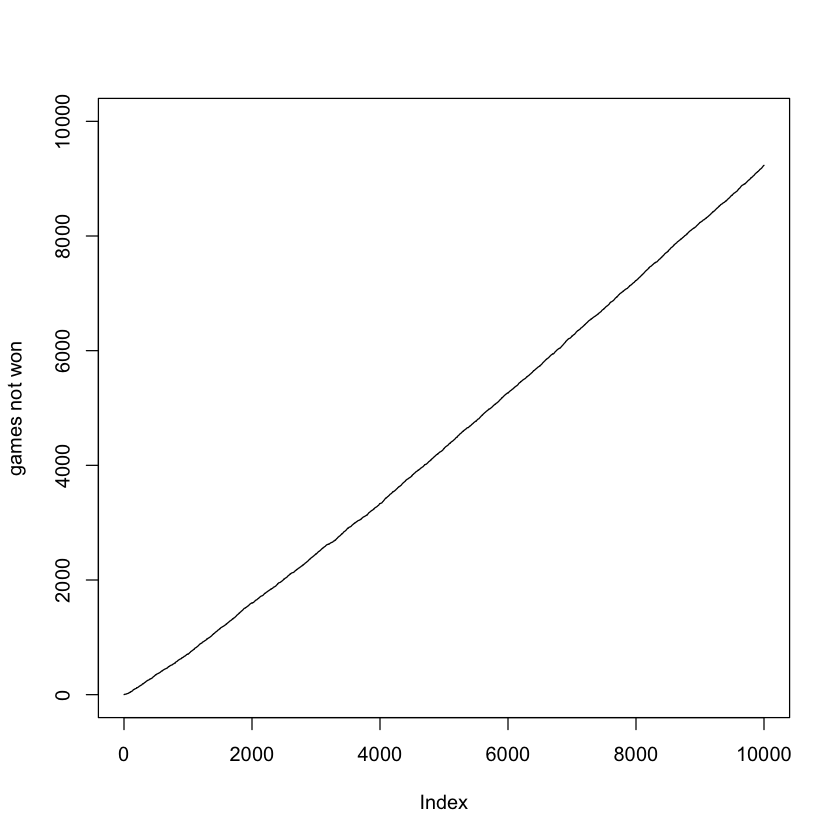

In [13]:
strategyLearn <- hash()
historyLearn <- list(n = 0, results = NA, games = list())

waitUntilStep <- 500
clearEvery <- 500
keepMin <- 500
numGames <- 10000
player1 <- "playerLearn" 
player2 <- "playerRandom" 
totalResults <- c()
totalGames <- 1

########################################
# adjust values for lambda and doStepEvery
lambda <- 20
doStepEvery <- 1000
########################################

set.seed(20190623)
for(i in 1:numGames){
  game(player1, player2, silent = TRUE)  
  totalGames <- totalGames +1
}

# plot over performance
plot((1:numGames) - cumsum(totalResults), xlim = c(0,numGames), 
     ylim = c(0,numGames), ylab = "games not won", type = "l")

# percentage of last 1000 games that have been won
mean(tail(historyLearn$results,1000)==1)

In [141]:
strategyLearn[[toString(c(0,0,0,0,0,0,0,0,0))]] # largest entry 5
strategyLearn[[toString(c(-1,0,0,0,1,0,0,0,0))]] # largest entry 4
strategyLearn[[toString(c(-1,0,0,1,1,0,0,-1,0))]] # largest entry 6 -> WIN

[1] -0.4822166 -3.3098837  1.9719755  0.4550668  9.0603582 -6.2749539  0.6724127
[8] -3.6968303  1.6040713

[1]       -Inf -0.1674216 -1.8905173  6.5464983       -Inf -0.1780926 -0.7947581
[8] -2.4068976 -1.1088112

[1]       -Inf -1.3344270 -1.5091788       -Inf       -Inf  4.7297548 -1.3855034
[8]       -Inf -0.5006456

NULL